In [1]:
import math
import numpy as np
from disturbances import IntegratedWhiteNoise
import os
from constants import *
from diff_calc import get_mass_matrix
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
J = np.array([[1, 0, -(d_bf-(L_bc/2))],
              [0, -1, -d_ae],
              [1, 0, -d_bf], 
              [0, -1, (d_ad-d_ae)],
              [1, 0, (L_bc - d_bf)],
              [0, -1, (d_ad - d_ae)]])

f_a = 100
phi_a = 0

f_b = 0
phi_b = 0

f_c = 0
phi_c = 0

f = np.array([f_a*np.sin(phi_a), f_a*np.cos(phi_a), 
              f_b*np.sin(phi_b), f_b*np.cos(phi_b), 
              f_c*np.sin(phi_c), f_c*np.cos(phi_c)])


In [4]:
def get_thrust_7a(input_vec):
    J = np.array([[1, 0, -(d_bf - (L_bc / 2))],
                  [0, -1, -d_ae],
                  [1, 0, -d_bf],
                  [0, -1, (d_ad - d_ae)],
                  [1, 0, (L_bc - d_bf)],
                  [0, -1, (d_ad - d_ae)]])
    J = J.T

    J_plus = J.T @ np.linalg.inv(J @ J.T)
    return J_plus @ input_vec

In [5]:
get_thrust_7a(np.array([0, 100, 100]))

array([  0.        , -49.05193424,  -9.95260664, -25.47403288,
         9.95260664, -25.47403288])

In [15]:
f_x = 300
f_y = 0
n = 0

dv = (L_ac + L_bc)/2
J_star = np.array([[1, 0, -(d_bf-(L_bc/2))/dv],
                   [0, -1, -d_ae/dv],
                   [1, 0, -d_bf/dv],
                   [0, -1, (d_ad-d_ae)/dv],
                   [1, 0, (L_bc - d_bf)/dv],
                   [0, -1, (d_ad - d_ae)/dv]])

J_star_plus = J_star @ np.linalg.inv(J_star.T @ J_star)

q_star = np.array([f_x, f_y, n])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 6 is different from 3)

In [34]:
def get_thrust_msgs(input_vec):
    dv = (L_ac + L_bc) / 2
    J_star = np.array([[1, 0, -(d_bf - (L_bc / 2)) / dv],
                       [0, -1, -d_ae / dv],
                       [1, 0, -d_bf / dv],
                       [0, -1, (d_ad - d_ae) / dv],
                       [1, 0, (L_bc - d_bf) / dv],
                       [0, -1, (d_ad - d_ae) / dv]])
    J_star = J_star.T

    J_star_plus = J_star.T @ np.linalg.inv(J_star @ J_star.T)
    # q_star = np.array([input_vec[0], input_vec[1], input_vec[2]/dv])
    q_star = input_vec
    return J_star_plus @ q_star

In [35]:
get_thrust_msgs(np.array([100, 0, 100]))

array([ 33.33333333, -62.87440361,  -6.47709321,  31.4372018 ,
        73.14375987,  31.4372018 ])

In [27]:
n = np.empty((3, 0))
n = np.column_stack((n, np.array([1, 2, 3])))
np.column_stack((n, np.array([1, 2, 3])))

array([[1., 1.],
       [2., 2.],
       [3., 3.]])

In [3]:
# Reading from a MCAP file
from mcap_ros2.reader import read_ros2_messages


def interpolate(array):
    return np.interp(np.arange(0, 6000, 1), np.arange(0, len(array), 1), array)

pos = np.empty((3, 0))
vel = np.empty((3, 0))
acc = np.empty((3, 0))

for msg in read_ros2_messages("../bagfiles/record7/record7_0.mcap"):
    if msg.channel.topic == "/model/vereniki/odometry":
        # print(f"{msg.ros_msg.pose.pose.position.x}: \n")
        pos = np.column_stack((pos, np.array([msg.ros_msg.pose.pose.position.x,
                                              msg.ros_msg.pose.pose.position.y,
                                              msg.ros_msg.pose.pose.orientation.z])))
        vel = np.column_stack((vel, np.array([msg.ros_msg.twist.twist.linear.x,
                                              msg.ros_msg.twist.twist.linear.y,
                                              msg.ros_msg.twist.twist.angular.z])))
    if msg.channel.topic == "/model/vereniki/imu":
        # print(f"{msg.ros_msg.linear_acceleration.x}")
        acc = np.column_stack((acc, np.array([msg.ros_msg.linear_acceleration.x,
                                              msg.ros_msg.linear_acceleration.y,
                                              0])))

    
odom_data = {'Position-x': pos[0, :], 
        'Position-y': pos[1, :], 
        'Orientation-z': pos[2, :],
        'Velocity-x': vel[0, :],
        'Velocity-y': vel[1, :],
        'Velocity-z': vel[2, :]}

imu_data= {'Acceleration-x': acc[0, :],
           'Acceleration-y': acc[1, :],
           'Acceleration-z': acc[2, :]}
odom_sim_data = pd.DataFrame(odom_data)
imu_sim_data = pd.DataFrame(imu_data)

In [4]:
odom_sim_data

,Position-x,Position-y,Orientation-z,Velocity-x,Velocity-y,Velocity-z
0,0.006393,0.000006,-0.000002,0.001982,2.369743e-04,-7.218222e-05
1,0.006471,0.000012,-0.000002,0.004539,3.724058e-04,-8.883787e-05
2,0.006600,0.000022,-0.000002,0.007073,4.988151e-04,-1.002205e-04
3,0.006779,0.000033,-0.000002,0.009587,6.143253e-04,-1.056001e-04
4,0.007008,0.000047,-0.000002,0.012083,7.190326e-04,-1.044982e-04
...,...,...,...,...,...,...
3030,25.787689,0.031387,0.000608,0.447459,-1.181123e-09,6.494612e-08
3031,25.796638,0.031398,0.000608,0.447459,-1.177565e-09,6.494612e-08
3032,25.805587,0.031409,0.000608,0.447459,-1.174011e-09,6.494612e-08
3033,25.814536,0.031420,0.000608,0.447459,-1.175667e-09,6.494612e-08


In [5]:
diff_data = pd.read_csv('output.csv')
diff_data

,Position-x,Position-y,Orientation-z,Velocity-x,Velocity-y,Velocity-z,Acceleration-x,Acceleration-y,Acceleration-z
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0
1,0.000000,0.0,0.0,0.001307,0.0,0.0,1.307190e-01,0.0,0.0
2,0.000013,0.0,0.0,0.002033,0.0,0.0,7.262088e-02,0.0,0.0
3,0.000033,0.0,0.0,0.003018,0.0,0.0,9.844117e-02,0.0,0.0
4,0.000064,0.0,0.0,0.003887,0.0,0.0,8.696328e-02,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5995,30.288124,0.0,0.0,0.542884,0.0,0.0,7.478133e-10,0.0,0.0
5996,30.293553,0.0,0.0,0.542884,0.0,0.0,7.453227e-10,0.0,0.0
5997,30.298982,0.0,0.0,0.542884,0.0,0.0,7.428403e-10,0.0,0.0
5998,30.304411,0.0,0.0,0.542884,0.0,0.0,7.403663e-10,0.0,0.0


In [6]:
selected_indices = np.linspace(0, len(diff_data['Position-x'])-1, 3035, dtype=int)
diff_data.iloc[selected_indices, 0]

0        0.000000
1        0.000000
3        0.000033
5        0.000102
7        0.000208
          ...    
5991    30.266409
5993    30.277267
5995    30.288124
5997    30.298982
5999    30.309840
Name: Position-x, Length: 3035, dtype: float64

In [24]:
diff_data.iloc[selected_indices, 0].reset_index(drop=True)

0        0.000000
1        0.000000
2        0.000033
3        0.000102
4        0.000208
          ...    
3030    30.266409
3031    30.277267
3032    30.288124
3033    30.298982
3034    30.309840
Name: Position-x, Length: 3035, dtype: float64

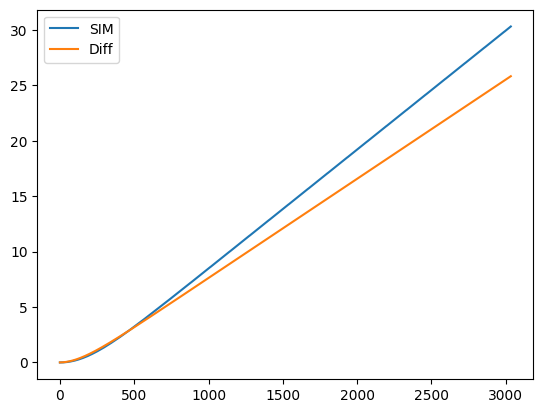

In [25]:
plt.plot(diff_data.iloc[selected_indices, 0].reset_index(drop=True), label='SIM')
plt.plot(odom_sim_data['Position-x'], label='Diff')
plt.legend()
plt.show()

In [89]:
diff_data

,Position-x,Position-y,Orientation-z,Velocity-x,Velocity-y,Velocity-z,Acceleration-x,Acceleration-y,Acceleration-z
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0
1,0.000000,0.0,0.0,0.001307,0.0,0.0,1.307190e-01,0.0,0.0
2,0.000013,0.0,0.0,0.002033,0.0,0.0,7.262088e-02,0.0,0.0
3,0.000033,0.0,0.0,0.003018,0.0,0.0,9.844117e-02,0.0,0.0
4,0.000064,0.0,0.0,0.003887,0.0,0.0,8.696328e-02,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5995,30.288124,0.0,0.0,0.542884,0.0,0.0,7.478133e-10,0.0,0.0
5996,30.293553,0.0,0.0,0.542884,0.0,0.0,7.453227e-10,0.0,0.0
5997,30.298982,0.0,0.0,0.542884,0.0,0.0,7.428403e-10,0.0,0.0
5998,30.304411,0.0,0.0,0.542884,0.0,0.0,7.403663e-10,0.0,0.0
